# OSM Downloading

## Import Packages

In [13]:
import geopandas as gpd
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import importlib
import numpy as np

#custom
from osm_dwnld import * #contains functions for downloaded data from OSMnx and Overpass API

# Filepaths and Projection

In [14]:
studyarea_fp = Path.home() / 'Documents/GitHub/BikewaySimDev/Data/boundaries.geojson'
project_dir = Path.home() / 'Documents/GitHub/BikewaySimDev/Data/networks'
crs = "epsg:2226"

## Download OSM geometry using OSMnx and attribute data using Overpass API
More info about OSMnx: https://geoffboeing.com/2016/11/osmnx-python-street-networks/  
OSMnx documentation: https://osmnx.readthedocs.io/en/stable/index.html

If you already know all the OSM edge attributes you want to retain. Provide it as a list of string in the "desired_osm_attributes" argument in the the download_osm function.

c:\Users\tpassmore6\Anaconda3\envs\geo-env\lib\site-packages\osmnx\utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
c:\Users\tpassmore6\Anaconda3\envs\geo-env\lib\site-packages\osmnx\utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
c:\Users\tpassmore6\Anaconda3\envs\geo-env\lib\site-packages\osmnx\utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


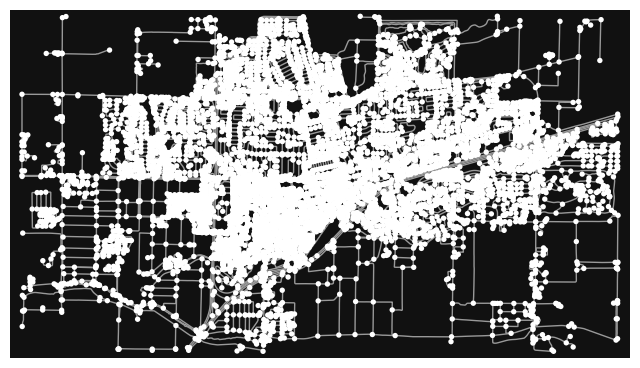

The bounding box is -121.8125621, 38.5153759, -121.6756663, 38.5755508


c:\Users\tpassmore6\Documents\GitHub\BikewaySimDev\osm_dwnld.py:146: FutureWarning: The default value of regex will change from True to False in a future version.
  df.columns = df.columns.str.replace(r'tags.', '')


nodes column removed for containing a list


In [15]:
osm_nodes, osm_links = download_osm(studyarea_fp,crs,project_dir)

## Reduce attributes

In [16]:
#set cutoff
percent_complete_cutoff=10

#get length and total length
network_length = osm_links.length
total_network_length = osm_links.length.sum()

#get percent complete weighted by total distance
attr_completion = osm_links.notna().apply(lambda col: col*network_length,axis=0).sum() / total_network_length * 100
attr_completion.name = 'percent_complete'

#retrieve all complete* fields
complete = list(attr_completion[attr_completion>percent_complete_cutoff].index)
#less_complete = list(attr_completion[attr_completion<=percent_complete_cutoff].index)

# road attributes to retreive
road_columns = ['highway','name','highway_1','oneway','lanes','maxspeed','bridge','crossing','sidewalk']

# parking attributes
parking_columns = [x for x in osm_links.columns.to_list() if 'parking' in x]

# bike attributes
bike_columns = [x for x in osm_links.columns.to_list() if (('cycle' in x) | ('bike' in x)) & ('motorcycle' not in x)]
foot_columns = [x for x in osm_links.columns.to_list() if ('foot' in x)]
bike_columns = bike_columns + foot_columns

#keep these columns
keep = complete+bike_columns+road_columns+parking_columns

#remove excess columns
osm_export = osm_links[set(osm_links.columns) & set(keep)]

# Make boxplot of attribute completion
marks = np.array(attr_completion)

#removed columns
removed_cols = [ x for x in osm_links.columns if x not in keep]

## Attribute Completion

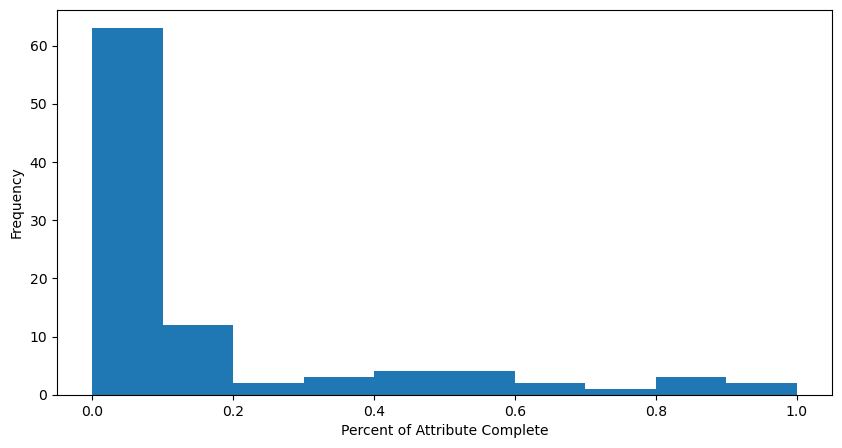

In [17]:
fig, axis = plt.subplots(figsize =(10, 5))
axis.hist(marks, bins = np.array([x for x in range(0, 110, 10)]) / 100)
plt.xlabel('Percent of Attribute Complete')
plt.ylabel('Frequency')
# Displaying the graph
plt.show()

## Export

In [18]:
osm_nodes.to_file(project_dir / 'osm.gpkg',layer='nodes')
osm_export.to_file(project_dir / 'osm.gpkg',layer='links')

## Examining Results

In [19]:
#don't run if large network
#osm_links.explore()

### Which columns to keep?
1. Check for completion
1. Check for desired attributes (speed, bike lanes, etc.)
1. Filter to just those

### Examine which attributes are present
Try 'maxspeed' or 'lanes'

In [20]:
#others to check: 'cycleway','lanes'
attributes_to_check = ['maxspeed']
osm_links.loc[osm_links[attributes_to_check].notna().any(axis=1),attributes_to_check+['geometry']].explore()

## Look at value counts to look at possible attribute values

In [21]:
osm_links['lanes'].value_counts()

2    591
1    169
3    157
4     61
5     13
6      3
Name: lanes, dtype: int64

# Just Bike Infrastructure

In [22]:
#create copy
bike_lanes = osm_links.copy()

#drop if no on bicycle
bike_lanes = bike_lanes[bike_lanes['bicycle']!='no']

#drop shared lanes "sharrows"
not_sharedlane = (-bike_lanes[bike_columns].isin(['shared_lane'])).all(axis=1)
bike_lanes = bike_lanes[not_sharedlane]

#remove sidewalks unless bikes explicitly allowed
remove_sidewalks = (bike_lanes['footway'].isin(['sidewalk','crossing'])) & (bike_lanes['bicycle'] != 'yes')
bike_lanes = bike_lanes[-remove_sidewalks]

#drop unless at least one bike attribute or if cycleway is present in highway or highway_1
bike_lanes = bike_lanes[~(bike_lanes[bike_columns].isna().all(axis=1)) | (bike_lanes['highway']=='cycleway')]

#need beltline and stuff
bike_lanes[['name','highway']+bike_columns+['geometry']].explore()

# Quick Export
- Remove restricted access roads
- Remove sidewalks

In [23]:
# links = osm_export.copy()

# #remove restricted access roads + sidewalks
# restr_access = links['highway'].isin(['motorway','motorway_link'])
# links = links[-restr_access]

# #remove sidewalks unless bikes explicitly allowed
# remove_sidewalks = (links['footway'].isin(['sidewalk','crossing'])) & (links['bicycle'] != 'yes')
# links = links[-remove_sidewalks]    

# #find service links that still have a name
# service_links_with_name = links[ (links['highway'] == 'service') & (links['name'].isnull() == False) ]

# osm_filter_method = ['primary','primary_link','residential','secondary','secondary_link',
#                     'tertiary','tertiary_link','trunk','trunk_link','cycleway','footway','path','pedestrian','steps'] 

# links = links[links["highway"].isin(osm_filter_method)]

# #add back in service links with a name
# links = links.append(service_links_with_name)

# #remove nodes that aren't in filtered links
# nodes = links['A'].append(links['B']).unique()
# osm_nodes_filt = osm_nodes[osm_nodes['osmid'].isin(nodes)]

# #export these two
# links.to_file(project_dir / f'osm/{studyarea_name}.gpkg',layer='quick_links')
# osm_nodes_filt.to_file(project_dir / f'osm/{studyarea_name}.gpkg',layer='quick_nodes')

Sometimes, there are duplicate attribute names in OSM. The below code drops duplicate column names by first appearance

In [24]:
#get rid of duplicate columns names
#overpass_links = overpass_links.iloc[:,overpass_links.columns.str.lower().duplicated(keep='first') == False]
